# Проект "Автоматизация коммуникаций"
## Задача

Ежедневно Wildberries получает огромное количество различных обращений клиентов по различным вопросам и из разных источников. Многие из этих обращений обрабатываются при помощи автоматизированных систем. Вам предстоит создать вопросно-ответную систему, которая генерирует ответ на обращения в техподдержку для менеджеров ПВЗ.

Вам будут доступны данные в виде истории вопросов и ответов на них, а также база знаний в виде документов, в которых содержится информация, регламентирующая работу менеджера на ПВЗ и описывающая многие бизнес-
процессы.

## 4. Оптимизация решения
На данном этапе вам необходимо:
- Оптимизировать работу выбранного решения
- Подобрать гиперпараметры
- Проанализировать насколько улучшилось качество работы алгоритма
- Проанализировать важные признаки

Сокращения:\
**АС** - Автоматизированная система

### **Recap предыдущего этапа**
---

#### **Baseline**


Для бейзлайна были выбраны следующие модели:
- Векторизация текстов (модель): RuBert
- Генерация ответов (модель): saiga_mistral_7b_lora
- Векторный поиск: Faiss

Pipeline:
1. Предобработка запроса и векторазиция
2. Векторный поиск в базе QA и базе знаний по запросу релеватных вопросов и чанков соответственно.
3. (для QA) Для найденного эталонного вопроса выбрать соответствующий эталонный ответ, векторизовать
4. Векторный поиск в базе знаний по эталонному ответу чанков.
5. Агрегировать полученные результаты (промпты) и сгенерировать ответ.

#### **Валидация**


Валидация представляет из себя следующее:
1. Оценка векторных представлений (RuBert)
    - визуальный анализ
    - качество на решаемой задаче
2. Оценка генерируемого ответа (saiga_mistral_7b_lora)
    - Rouge: Recall Oriented Understudy for Gisting Evaluation
    - BLEU : Bilingual Evaluation Understudy Score
    - METEOR: Metric for Evaluation of Translation with Explicit Ordering

### **Оптимизация решения**
---

На предыдущем этапе были выявлены следующие недостатки:
- Медленная скорость генерации ответа
- Низкие значение метрик качества BLEU, ROUGE, METEOR.

Способы устранения недостатков
- Скорость генерации
    - использовать другую модель
    - подобрать параметры конфигурации (generation config)
- Качество ответов
    - Дообучение линейного слоя RuBert
    - Промпт-инжениринг (выбирать не топ-1 для каждого соответствия (запрос-чанк, эталонный ответ-чанк), а отбирать небольшую выборку с последующей фильтрацией)
    - Применить задачу NER для фильтрации результатов

Дальнешая оптимизация:
- partitioning the index (Faiss), увеличение скорости ответа
- обеспечить более оптимальное хранение данных, например, чтение из базы данных, вместо ОЗУ
- применить квантизацию моделей

#### **Cкорость генерации ответа**

За кулисами были рассмотрены следующие **модели**:
- `IlyaGusev/saiga_mistral_7b_lora`
- `TheBloke/saiga_mistral_7b-GPTQ`
- `ai-forever/rugpt3large_based_on_gpt2`
- `ai-forever/mGPT`
- `NousResearch/Llama-2-7b-chat-hf`
- `BlinkDL/rwkv-5-world`
- `Gigachat`
- `YandexGPT`
- `OpenAI`

Модели `IlyaGusev/saiga_mistral_7b_lora`, `TheBloke/saiga_mistral_7b-GPTQ`, `NousResearch/Llama-2-7b-chat-hf` одинаково медленно генерируют ответ.

Модели `ai-forever/rugpt3large_based_on_gpt2`, `ai-forever/mGPT` помимо медленной генерации показали неадекватность ответов.

Модели `Gigachat`, `YandexGPT`, `OpenAI` платные, однако, есть бесплатные версии с ограничениями.

Стоит отметить модель `BlinkDL/rwkv-5-world`. Она имеет наибольшее количество оценок на hf - модель показывает высокую скорость генерации ответа. Есть несколько минусов:
- сложность установки модели
- ответы на английском языке

**Выводы**\
Не удалось подобрать более быструю модель генерации ответа. Однако, есть возможность разобраться с моделью `BlinkDL/rwkv-5-world` и использовать рядом с ней MT-модель.

**UPDATE**\
Была опробована модель `OpenAI API | GPT 3.5 Turbo` с ограничениями, которая показала большой прирост в скорости генерации ответа - 1 749ms

#### **Параметры конфигурации (generation config)**

- Parameters that control the length of the output
    - max_length — The maximum length the generated tokens can have. Corresponds to the length of the input prompt + max_new_tokens. Its effect is overridden by max_new_tokens, if also set.
    - max_new_tokens — The maximum numbers of tokens to generate, ignoring the number of tokens in the prompt.
    - early_stopping — Controls the stopping condition for beam-based methods, like beam-search. It accepts the following values: 
    - max_time — The maximum amount of time you allow the computation to run for in seconds. generation will still finish the current pass after allocated time has been passed.

- Parameters that control the generation strategy used
    - do_sample — Whether or not to use sampling ; use greedy decoding otherwise.
    - num_beams — Number of beams for beam search. 1 means no beam search.
    - penalty_alpha (float, optional) — The values balance the model confidence and the degeneration penalty in contrastive search decoding.
    - use_cache — Whether or not the model should use the past last key/values attentions (if applicable to the model) to speed up decoding.

- Parameters for manipulation of the model output logits
    - temperature — The value used to modulate the next token probabilities.
    - top_k — The number of highest probability vocabulary tokens to keep for top-k-filtering.
    - top_p — If set to float < 1, only the smallest set of most probable tokens with probabilities that add up to top_p or higher are kept for generation.
    - epsilon_cutoff — If set to float strictly between 0 and 1, only tokens with a conditional probability greater than epsilon_cutoff will be sampled. In the paper, suggested values range from 3e-4 to 9e-4, depending on the size of the model. See Truncation Sampling as Language Model Desmoothing for more details.
    - no_repeat_ngram_size — If set to int > 0, all ngrams of that size can only occur once.
    - force_words_ids — List of token ids that must be generated. If given a List[List[int]], this is treated as a simple list of words that must be included, the opposite to bad_words_ids. If given List[List[List[int]]], this triggers a disjunctive constraint, where one can allow different forms of each word.
    - guidance_scale - The guidance scale for classifier free guidance (CFG). CFG is enabled by setting guidance_scale > 1. Higher guidance scale encourages the model to generate samples that are more closely linked to the input prompt, usually at the expense of poorer quality.
    
**UPDATE**\
    Были переопределены параметры:
- temperature = 0.4
- max_new_token = 500

#### **Промпт-инжениринг**

Идея отбора промптов следующая.
Формируются три набора промптов:
1. Эталонный ответ
2. Чанки, найденнные по векторному представлению запроса
3. Чанки, найденные по векторному представлению эталона

Было обнаружено, что ближайший найденный промпт в результате векторного поиска не всегда лучший. Поэтому необходимо отбирать несколько промптов в рамказ одного набора.

Отбор проводится следующим образом:
1. В результате векторного поиска находятся все расстояния до переданного вектора
2. Так как метрика расстояния inner product, то проводится фильтрация расстояний по положительному знаку величин
3. Далее, проверяется принадлежность распределения расстояний нормальному распределению на основе сравнения среднего и моды распределения по заданному порогу
4. В случае нормального распределения выбираются наибольшие величины, выходящие за +-3*sigma диапазона величин.

#### *Освобождение памяти GPU

In [1]:
!pip install GPUtil > None

In [2]:
from GPUtil import showUtilization as gpu_usage

gpu_usage()          

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |


#### **Ход работы**

In [3]:
# установка библиотек
!pip install peft
!conda install -c pytorch faiss-gpu -y
!pip install -q -U bitsandbytes accelerate transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 2.6 MB/s eta 0:00:0000:010:01
Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    faiss-gpu-1.8.0            |py3.10_h4c7d538_0_cuda12.1.1         5.0 MB  pytorch
    libfaiss-1.8.0             |h046e95b_0_cuda12.1.1       268.9 MB  pytorch
    openssl-3.3.0              |       hd590300_0         2.8 MB  conda-forge
    ------------------------------------------------------------
 

In [4]:
!pip install rouge
!pip install nltk==3.8.1

import nltk
download_dir = '/kaggle/working/nltk_data'
nltk.download('wordnet', download_dir=download_dir)
nltk.data.path.append(download_dir)

!unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora/ -y

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.6 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...


Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
caution: filename not matched:  -y


In [5]:
# подключение библиотек
import re
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import gc
import torch
import torch.nn.functional as F
import transformers
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import faiss

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk import word_tokenize
from rouge import Rouge 

In [6]:
# глобальные переменные конфигурации
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LLM_MODEL_NAME = "IlyaGusev/saiga_mistral_7b"
LLM_DEFAULT_MESSAGE_TEMPLATE = "<s>{role}\n{content}</s>"
LLM_DEFAULT_RESPONSE_TEMPLATE = "<s>bot\n"
LLM_DEFAULT_SYSTEM_PROMPT = "Ты — Сайга, русскоязычный автоматический ассистент. Ты разговариваешь с людьми и помогаешь им."
EMBEDDER_MODEL_NAME = "DeepPavlov/rubert-base-cased"

In [7]:
# очистка мусора в тексте
def clean_html(raw):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    raw = re.sub(cleanr, ' ', raw)
    raw = re.sub('< nt >', '. ', raw)
    cleantext = re.sub("\\n", '. ', raw)
    return cleantext

# метрики качества генерации
def calculate_bleu(candidate, reference):
    '''
    candidate, reference: generated and ground-truth sentences
    '''
    reference = word_tokenize(reference)
    candidate = word_tokenize(candidate)
    score = sentence_bleu(reference, candidate)
    return score


def calculate_rouge(candidate, reference):
    '''
    candidate, reference: generated and ground-truth sentences
    '''
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference)
    return scores


def calculate_meteor(candidate, reference):
  '''
  candidate, reference: tokenized list of words in the sentence
  '''
  reference = word_tokenize(reference)
  candidate = word_tokenize(candidate)
  score = round(meteor_score([candidate],reference), 4)
  return score

In [8]:
# Класс истории диалога
class Conversation:
    def __init__(
        self,
        message_template=LLM_DEFAULT_MESSAGE_TEMPLATE,
        system_prompt=LLM_DEFAULT_SYSTEM_PROMPT,
        response_template=LLM_DEFAULT_RESPONSE_TEMPLATE
    ):
        self.message_template = message_template
        self.response_template = response_template
        self.messages = [{
            "role": "system",
            "content": system_prompt
        }]

    def add_user_message(self, message):
        self.messages.append({
            "role": "user",
            "content": message
        })

    def add_bot_message(self, message):
        self.messages.append({
            "role": "bot",
            "content": message
        })

    def get_prompt(self, tokenizer):
        final_text = ""
        for message in self.messages:
            message_text = self.message_template.format(**message)
            final_text += message_text
        final_text += LLM_DEFAULT_RESPONSE_TEMPLATE
        return final_text.strip()


In [9]:
# Класс RAG-системы
class RAG:    
    def __average_pool(self, last_hidden_states, attention_mask):
        """
        Функция, возвращает эмбеддинги с последнего слоя
        """
        last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
    
    def __init_embedder(self):
        """
        Инициализация LLM-модели для получения векторных представлений текстов
        """
        self.embedder_model = transformers.AutoModel.from_pretrained(EMBEDDER_MODEL_NAME)
        self.embedder_tokenizer = transformers.AutoTokenizer.from_pretrained(EMBEDDER_MODEL_NAME)
        self.embedder_model.to(self.device)
        self.emb_dim = 768
        
    def __init_llm_generator(self):
        """
        Инициализация LLM-модели для генерации текста
        """
        self.llm_config = PeftConfig.from_pretrained(LLM_MODEL_NAME)
        self.llm_model = AutoModelForCausalLM.from_pretrained(
            self.llm_config.base_model_name_or_path,
            load_in_8bit=True,
            torch_dtype=torch.float16,
            device_map="auto"
        )
        self.llm_model = PeftModel.from_pretrained(
            self.llm_model,
            LLM_MODEL_NAME,
            torch_dtype=torch.float16
        )
        self.llm_model.eval()
        self.llm_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_NAME, use_fast=False)
        self.generation_config = GenerationConfig.from_pretrained(LLM_MODEL_NAME)
        self.generation_config.max_new_tokens = 500
        self.generation_config.temperature = 0.4
    
    def __init__(self, knowledge_base, qa_pairs, device):
        """
        Конструктор класса RAG
        """
        self.device = device
        
        # инициализация моделей
        self.__init_embedder()
        self.__init_llm_generator()

        # инициализация диалога
        self.conversation = Conversation()
        
        # сохранение данных
        self.knw_base = knowledge_base
        self.qa_base = qa_pairs

        # векторизация базы знаний и создание индекса
        chunk_embs = self.vectorize(self.knw_base['chunk'])
        self.chunk_index = faiss.IndexFlatIP(self.emb_dim)
        self.chunk_index.add(chunk_embs)

        # векторизация вопросов и создание индекса
        ques_embs = self.vectorize(self.qa_base['question'])
        self.ques_index = faiss.IndexFlatIP(self.emb_dim)
        self.ques_index.add(ques_embs)
    
    @torch.no_grad()
    def vectorize(self, data):
        """
        Получение векторных представлений текстов
        """
        data_vectorized = np.zeros((len(data), self.emb_dim))
        for index, sentence in enumerate(data):
            batch_dict = self.embedder_tokenizer(sentence,
                                      max_length=512,
                                      padding=True,
                                      truncation=True,
                                      return_tensors='pt').to(self.device)
            outputs = self.embedder_model(**batch_dict)
            embeddings = self.__average_pool(outputs.last_hidden_state,
                                             batch_dict['attention_mask'])
            data_vectorized[index] = embeddings.cpu().detach().numpy()
        return data_vectorized
    
    def generate(self, input):
        """
        Функция, генерирует ответ на запрос пользователя
        """
        self.conversation.add_user_message(input)
        
        prompt = self.conversation.get_prompt(self.llm_tokenizer)
        data = self.llm_tokenizer(prompt, return_tensors="pt")
        data = {k: v.to(self.llm_model.device) for k, v in data.items()}
        output_ids = self.llm_model.generate(
            **data,
            generation_config=self.generation_config
        )[0]
        output_ids = output_ids[len(data["input_ids"][0]):]
        output = self.llm_tokenizer.decode(output_ids, skip_special_tokens=True).strip()
        
        self.conversation.add_bot_message(output)
        return output
    
    def ask(self, user_request):
        """
        Функция поиска чанков и генерации ответа на запрос пользователя
        """
        k_neighbours=(self.qa_base.size, rag.knw_base.size)
        
        user_request = clean_html(user_request)
        user_request_vector = self.vectorize([user_request])
        
        # поиск чанков по запросу
        chunk_distances_by_req, chunk_indexes_by_req = self.chunk_index.search(user_request_vector, k_neighbours[1])

        # поиск чанков по эталону
        ques_distances_by_req, ques_indexes_by_req = self.ques_index.search(user_request_vector, k_neighbours[0])
        standard_answer = self.qa_base['answer'].iloc[ques_indexes_by_req[0][0]]
        standard_answer_vector = self.vectorize([standard_answer])
        chunk_distances_by_st, chunk_indexes_by_st = self.chunk_index.search(standard_answer_vector, k_neighbours[1])

        # фильтрация результатов         
        chunk_distances_by_req = chunk_distances_by_req[0][chunk_distances_by_req[0] > 0]
        chunk_distances_by_st = chunk_distances_by_st[0][chunk_distances_by_st[0] > 0]

        if (chunk_distances_by_req.mean() - st.mode(chunk_distances_by_req).mode) / st.mode(chunk_distances_by_req).mode <= 0.2:
            chunk_distances_by_req = chunk_distances_by_req[chunk_distances_by_req >= np.median(chunk_distances_by_req) + 3 * np.std(chunk_distances_by_req, ddof=1)]
        else:
            chunk_distances_by_req = []

        if (chunk_distances_by_st.mean() - st.mode(chunk_distances_by_st).mode) / st.mode(chunk_distances_by_st).mode <= 0.2:
            chunk_distances_by_st = chunk_distances_by_st[chunk_distances_by_st >= np.median(chunk_distances_by_st) + 3 * np.std(chunk_distances_by_st, ddof=1)]
        else:
            chunk_distances_by_st = []


        if len(chunk_distances_by_req) != 0:
            answer_by_req = self.knw_base['chunk'].iloc[chunk_indexes_by_req[0][:chunk_distances_by_req.size]]
        if len(chunk_distances_by_st) != 0:
            answer_by_st = self.knw_base['chunk'].iloc[chunk_indexes_by_st[0][:chunk_distances_by_st.size]]
        
        # генерация ответа
        answer_by_req = []
        answer_by_st = []
        if len(chunk_distances_by_req) != 0:
            answer_by_req = list(self.knw_base['chunk'].iloc[chunk_indexes_by_req[0][:len(chunk_distances_by_req)]])
        if len(chunk_distances_by_st) != 0:
            answer_by_st = list(self.knw_base['chunk'].iloc[chunk_indexes_by_st[0][:len(chunk_distances_by_st)]])

        answers = (answer_by_req + answer_by_st)[:9]
        input = f"""
            вопрос: {user_request}
            промпты: \n
        """
        input += f"{standard_answer}\n"
        for item in answers:
            input += f"{item}\n"
        
        output = self.generate(input)
        return output 
    
    def clean_history(self):
        """
        Функция для очистки истории сообщений
        """
        del self.conversation
        self.conversation = Conversation()
    
    def __del__(self):
        """
        Деструктор, удаляет LLM-модели из памяти GPU
        """
        variables = [self.embedder_model, self.llm_model]
        for var in variables:
            del var
            gc.collect()
            torch.cuda.empty_cache()

### Чтение данных

In [10]:
knowledge_base = pd.read_excel('/kaggle/input/rag-datasers/knowledge_base.xlsx')
qa_pairs = pd.read_excel('/kaggle/input/rag-datasers/QA_pairs.xlsx')

### RAG-система

In [11]:
rag = RAG(knowledge_base, qa_pairs, device)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequence

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/54.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


generation_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

In [12]:
print(rag.ask('Как оформить возврат?'))

2024-05-16 01:24:15.600773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 01:24:15.600872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 01:24:15.715232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Возврат товара можно оформить следующим образом:

1. Получить акт о возврате от клиента. Акт должен быть подписан клиентом и содержать информацию об имени и адресе получателя, названии и коде товара, количестве и ценах.
2. Сделать фотографию акта о возврате и приложить ее к заявке.
3. Добавить комментарий к заявке, где указывается причина возврата, состояние товара и другие важные детали.
4. Поместить акт о возврате в коробку вместе с товаром и передать его на склад.
5. Проверить, что не прошло 30 дней со дня одобрения заявки. Если это так, то можно добавить товар в коробку для возврата и отправить его на склад.

После всех этих шагов, ваша заявка будет рассмотрена, и вы получите деньги в течение предполагаемого времени.


In [13]:
print(rag.ask('Как добавить сотрудника в черный список?'))

Для добавления сотрудника в черный список необходимо выполнить следующие шаги:

1. Найдите в системе сотрудника, которого хотите добавить в черный список.
2. Откройте страницу с информацией о сотруднике.
3. В разделе "Черный список" нажмите кнопку "Добавить".
4. Выберите причину добавления сотрудника в черный списоk.
5. Сохраните изменения.

После выполнения этих шагов сотрудник будет добавлен в черный список, и его будут запрещать работать на данном объекте.


### Валидация

Оценка генерируемого ответа (saiga_mistral_7b_lora)
- Rouge
- BLEU
- METEOR

#### Оценка генерируемого ответа

Наша задача - провалидировать LLM-модель, дополненную информацией из базы знаний

Рассматриваются 3 метрики:
- Rouge: Recall Oriented Understudy for Gisting Evaluation

    Метрика основана на вычислении синтаксического перекрытия между сгенерированным текстом и эталоном.\
    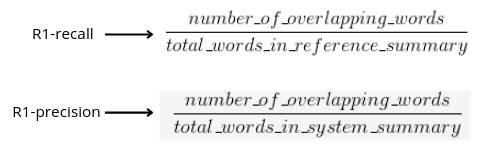

    Rouge-1, Rouge-2, Rouge-L и Rouge-S — некоторые часто вычисляемые числа.
        - Rouge-1 вычисляет перекрытие униграмм (отдельного слова) между фрагментами текстов. 
        - Rouge-2 вычисляет перекрытие биграмм (пар слов). 
        - Rouge-L вычисляет перекрытие самых длинных и одновременно встречающихся в последовательности n-грамм.
        - Rouge-S вычисляет перекрытие Skip - биграммы (любой пары слов в порядке их предложений).
    
    
- BLEU : Bilingual Evaluation Understudy Score

    BLEU — метрика для сравнения моделей в области NLG, ориентированная на precision, которая рассчитывает n-граммное перекрытие эталонного и сгенерированного текстов. Это перекрытие n-грамм означает, что схема оценки не зависит от позиции слова, за исключением терминологических ассоциаций n-грамм. В BLEU следует отметить одну вещь: существует штраф за краткость, то есть штраф, применяемый, когда сгенерированный текст слишком мал по сравнению с целевым текстом.
    
    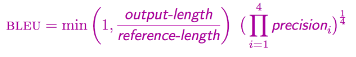

- METEOR: Metric for Evaluation of Translation with Explicit Ordering

    Имеет некоторые очевидные преимущества по сравнению с метрикой BLEU (популярной, когда дело доходит до оценки производительности систем машинного перевода), которая фокусируется на том, чтобы в основном отразить аспект точности генерации по сравнению с эталоном. METEOR, с другой стороны, основан на идее вычисления среднего гармонического значения униграмм precision и recall, где recall придается больший вес, чем precision. Придание большего значения recall позволяет нам лучше понять, какую часть эталона мы создали как часть вывода в процессе генерации.
    
    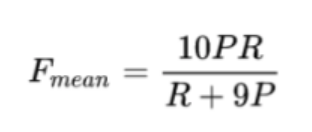
    
[Статья](https://blog.paperspace.com/automated-metrics-for-evaluating-generated-text/)

In [14]:
df_test = qa_pairs.sample(20)[['question', 'answer']]
df_test

,question,answer
115,нужно ли проверять документы при выдаче 18+?,товары категории 18+ включают в себя алкогольн...
2088,какие шк сканировать маркетплейс?,на всех пунктах выдачи доступна приёмка постав...
4952,пила - можно вернуть?,"если товар принесли из дома, то при необходимо..."
347,суммы за что вайлдберриз может вычесть из ежен...,штраф/неустойки/перерасчет удерживается с бала...
5607,заказать контроллер как собственник?,контроллер и блок питания мы предоставляем бес...
2511,бот возврат клиента,"если товар принесли на возврат из дома, то обя..."
564,можно ли удалить оценку в рейтинге?,"оценки и отзывы не оспариваются, подробнее с р..."
4421,"как принять, если шк повреждён?","если при приемке товара на нем отсутствует шк,..."
2330,регистрация как ип,для этого необходимо обратиться в налоговую ин...
1992,где находится настройки заполнения ячеек?,редактирование настроек при приемке возможно н...


In [15]:
quastions = list(df_test['question'])
candidates = []
references = []

for index, row in df_test.iterrows():
    candidates.append(rag.ask(row['question']))
    references.append(row['answer'])
    rag.clean_history()

In [16]:
for qua, ref, cand in zip(quastions, references, candidates):
    print("ВОПРОС:", qua)
    print()
    print("ЭТАЛОН:", ref)
    print()
    print("ГЕНЕРАЦИЯ:", cand)
    print('---'*100)

ВОПРОС: нужно ли проверять документы при выдаче 18+?

ЭТАЛОН: товары категории 18+ включают в себя алкогольные и слабоалкогольные напитки, интимные товары некоторых категорий, табачные изделия, включая вейпы, курительные смеси, трубки и прочие девайсы. продавать/передавать такие товары несовершеннолетним запрещается. если у клиента есть товар категории 18+, то при сомнении в его совершеннолетии, вы вправе запросить у него документ, удостоверяющий личность. вернуть такой товар клиент может только по одобренной заявке на брак в личном кабинете

ГЕНЕРАЦИЯ: При выдаче товара 18+ необходимо проверять документы, которые удостоверяют возраст клиента. Если клиент является несовершеннолетним, то он не имеет права приобретать такие товары. Если у клиента есть товар категории "18+", то при сомнении в его возрасте вы вправе запросить у него документ, который удостоверяет личность.

Если клиент не может или не хочет предоставить документы, то вам необходимо вернуть товар клиенту и закрыть заявку на

In [17]:
blue_data = np.zeros(df_test.shape[0])
rouge1_data, rouge2_data, rougel_data = [], [], []
meteor_data = np.zeros(df_test.shape[0])

for index, (ref, cand) in enumerate(zip(references, candidates)):
    blue_data[index] = calculate_bleu(cand, ref)
    rouge_data = calculate_rouge(cand, ref)[0]
    rouge1_data.append(rouge_data['rouge-1'])
    rouge2_data.append(rouge_data['rouge-2'])
    rougel_data.append(rouge_data['rouge-l'])
    meteor_data[index] = calculate_meteor(cand, ref)

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [18]:
rouge1_data = np.array([[item['f'], item['r'], item['p']] for item in rouge1_data])
rouge2_data = np.array([[item['f'], item['r'], item['p']] for item in rouge2_data])
rougel_data = np.array([[item['f'], item['r'], item['p']] for item in rougel_data])

In [19]:
df_metrics = pd.DataFrame(columns=['samples', 'mean metric', 'mediana of metric', 'std of metric', 'coefficient of variation'],
                         data=[[df_test.shape[0], blue_data.mean(), np.median(blue_data), blue_data.std(), blue_data.std() / blue_data.mean()],
                              [df_test.shape[0], rouge1_data.mean(axis=0)[0], np.median(rouge1_data, axis=0)[0], rouge1_data.std(axis=0)[0], rouge1_data.std(axis=0)[0] / rouge1_data.mean(axis=0)[0]],
                              [df_test.shape[0], rouge1_data.mean(axis=0)[1], np.median(rouge1_data, axis=0)[1], rouge1_data.std(axis=0)[1], rouge1_data.std(axis=0)[1] / rouge1_data.mean(axis=0)[1]],
                              [df_test.shape[0], rouge1_data.mean(axis=0)[2], np.median(rouge1_data, axis=0)[2], rouge1_data.std(axis=0)[2], rouge1_data.std(axis=0)[2] / rouge1_data.mean(axis=0)[2]],
                              [df_test.shape[0], rouge2_data.mean(axis=0)[0], np.median(rouge2_data, axis=0)[0], rouge2_data.std(axis=0)[0], rouge2_data.std(axis=0)[0] / rouge2_data.mean(axis=0)[0]],
                              [df_test.shape[0], rouge2_data.mean(axis=0)[1], np.median(rouge2_data, axis=0)[1], rouge2_data.std(axis=0)[1], rouge2_data.std(axis=0)[1] / rouge2_data.mean(axis=0)[1]],
                              [df_test.shape[0], rouge2_data.mean(axis=0)[2], np.median(rouge2_data, axis=0)[2], rouge2_data.std(axis=0)[2], rouge2_data.std(axis=0)[2] / rouge2_data.mean(axis=0)[2]],
                              [df_test.shape[0], rougel_data.mean(axis=0)[0], np.median(rougel_data, axis=0)[0], rougel_data.std(axis=0)[0], rougel_data.std(axis=0)[0] / rougel_data.mean(axis=0)[0]],
                              [df_test.shape[0], rougel_data.mean(axis=0)[1], np.median(rougel_data, axis=0)[1], rougel_data.std(axis=0)[1], rougel_data.std(axis=0)[1] / rougel_data.mean(axis=0)[1]],
                              [df_test.shape[0], rougel_data.mean(axis=0)[2], np.median(rougel_data, axis=0)[2], rougel_data.std(axis=0)[2], rougel_data.std(axis=0)[2] / rougel_data.mean(axis=0)[2]],
                              [df_test.shape[0], meteor_data.mean(), np.median(meteor_data), meteor_data.std(), meteor_data.std() / meteor_data.mean()]],
                         index=['BLEU', 'ROUGE-1-F1', 'ROUGE-1-Rec', 'ROUGE-1-Prec', 'ROUGE-2-F1', 'ROUGE-2-Rec', 'ROUGE-2-Prec', 'ROUGE-l-F1', 'ROUGE-l-Rec', 'ROUGE-l-Prec', 'METEOR'])
df_metrics

,samples,mean metric,mediana of metric,std of metric,coefficient of variation
BLEU,20,1.234520e-156,9.476175e-232,5.381147e-156,4.358899
ROUGE-1-F1,20,2.822829e-01,2.095532e-01,2.100069e-01,0.743959
ROUGE-1-Rec,20,3.599515e-01,2.520525e-01,2.273681e-01,0.631663
ROUGE-1-Prec,20,2.514650e-01,1.666667e-01,1.982827e-01,0.788510
ROUGE-2-F1,20,1.515488e-01,6.090123e-02,1.746659e-01,1.152539
ROUGE-2-Rec,20,1.866728e-01,8.737374e-02,2.027498e-01,1.086124
ROUGE-2-Prec,20,1.349318e-01,5.898058e-02,1.602543e-01,1.187669
ROUGE-l-F1,20,2.798296e-01,1.957478e-01,2.095040e-01,0.748684
ROUGE-l-Rec,20,3.561175e-01,2.520525e-01,2.259357e-01,0.634442
ROUGE-l-Prec,20,2.495603e-01,1.622807e-01,1.978793e-01,0.792912


**Выводы**\
Метрики качества показывают сильно низкие значения.

**UPDATE**\
Прироста значений метрик не произошло.